<a href="https://colab.research.google.com/github/PedroTurik/Competitions/blob/main/C%C3%B3pia_de_ANalise_Temporal_Futibas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto para o Datathon Scitek 2022: FutWizard

## Autores: Guilherme Arruda Brito, Pedro Turik Firmino e Matheus Blanco Tissot.

In [ ]:
# Importando as biblioteca que vamos utilizar: pandas e matplotlib
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Lendo os dados do arquivo "seg_info.csv"
df = pd.read_csv("seg_info.csv")

# Parâmetro global para definir o tamanho das figuras plotadas pelo matplotlib.pyplot
plt.rcParams["figure.figsize"] = (16, 9)

In [ ]:
# Limpando os dados:
# Queremos somente os dados 'video_name', 'cls_id', 'event_start_time' e 'highlight_cls', então podemos dropar as outras colunas
df = df.drop(['seg_id', 'start_time', 'end_time', 'event_end_time'], axis=1)

# Queremos apenas os dados em que houveram algum evento 'interessante'. Dados com 'cls_id'==0 são 'background': inúteis para a análise
df.drop(df[df['cls_id'] == '0'].index, inplace = True)

In [ ]:
# Alguns nomes de vídeos são divididos em 'nome_1' e 'nome_2', para primeiro e segundo tempo, respectivamente.
# Queremos modificar esses nomes para que possamos definir qual tempo estamos falando.

df['video_name'] = df['video_name'].map(lambda x: str(x)[-5])

In [ ]:
# Dividimos o jogo em bloco de 15 minutos, para ver quais etapas do jogo ocorrem mais eventos.
time_stamps = {
    (0,15) : [],
    (15,30) : [],
    (30,45) : [],
    (45,60) : [],
    (60,75) : [],
    (75,90) : []
}
aftertime = []


In [ ]:
# Como temos dados de jogos em 2 tempos (2 de 45), e jogos de tempo único (1 de 90), queremos padronizar isso.
# Este bloco adiciona 45 minutos aos tempos obtidos nos arquivos com 'nome_2', para que todos sejam contabilizados no intervalo [0-90].

for half, time, events, _ in df.itertuples(index=False):
    if str(half) == "1": # Se o nome tiver '_1', está no primeiro tempo, então deixamos igual.
        time_min = int(str(time)[3:5])
        
    elif str(half) == "2": # Se o nome tiver '_2', está no segundo tempo, então adicionamos 45 minutos ao seu tempo.
        time_min = int(str(time)[3:5]) + 45
  
    else:
        time_min = int(str(time)[3:5])
        time_min += int(str(time)[:2])*60 # Conversão de horas para minutos
  
    for frame in time_stamps:
        if frame[0] <= time_min < frame[1]:
            time_stamps[frame].append(str(events))
            break
    else:
        aftertime.append(str(events))


In [ ]:
# Dicionário em que iremos guardar a contagem de cada evento, em cada bin de tempo (0-15, 15-30, ...).
# Aqui apenas criamos um dicionário vazio, com chaves de '1' até '10', e com seus valores sendo listas [0, 0, 0, 0, 0, 0] (um valor para cada intervalo de 15 minutos)
events_per_time={str(i): [0 for _ in range(6)] for i in range(1, 11)}

In [ ]:
# Este bloco realiza a contagem de eventos em cada intervalo de tempo, e popula o dicionário.
for key in events_per_time:
    counter = 0
    for time in time_stamps:
        for x in time_stamps[time]: 
            if key in x:
                events_per_time[key][counter] += 1
        counter += 1


In [ ]:
def get_conversion(event):
    """Essa função recebe um parâmetro 'event', que conta quantos desse evento foram seguidos por gol, e compara com o total de eventos.
    A função retorna a porcentagem de 'eventos' convertidos em gol."""
    qtd = 0
    converted = 0
    for time in time_stamps:
        for x in time_stamps[time]: 
            if str(event) in x:
                qtd += 1
                if "10" in x:
                    converted += 1
    return converted/qtd

In [ ]:
# Essa função plota os gráficos de barra de cada parâmetro, em função do tempo de jogo.

def plot_grafico(n):
    translate = ["lesões", "cartões", "chutes", "substituições", "tiros livres", "escanteios", "defesas", "penaltis", "faltas", "gols"]
    tempos = [15, 30, 45, 60, 75, 90]

    plt.bar(tempos, events_per_time[str(n)], width=-14, align='edge')
    plt.xticks(tempos)
    plt.xlabel("Tempo de jogo")
    plt.ylabel("Eventos")
    plt.title(f"Série temporal de {translate[n-1]}")

    nome = translate[n-1]
    plt.savefig(nome+'.png')
    plt.show()

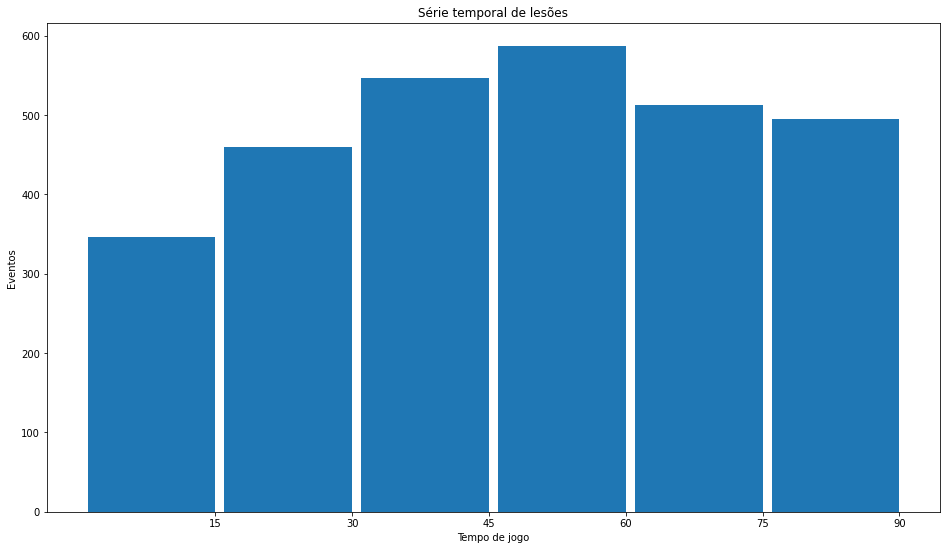

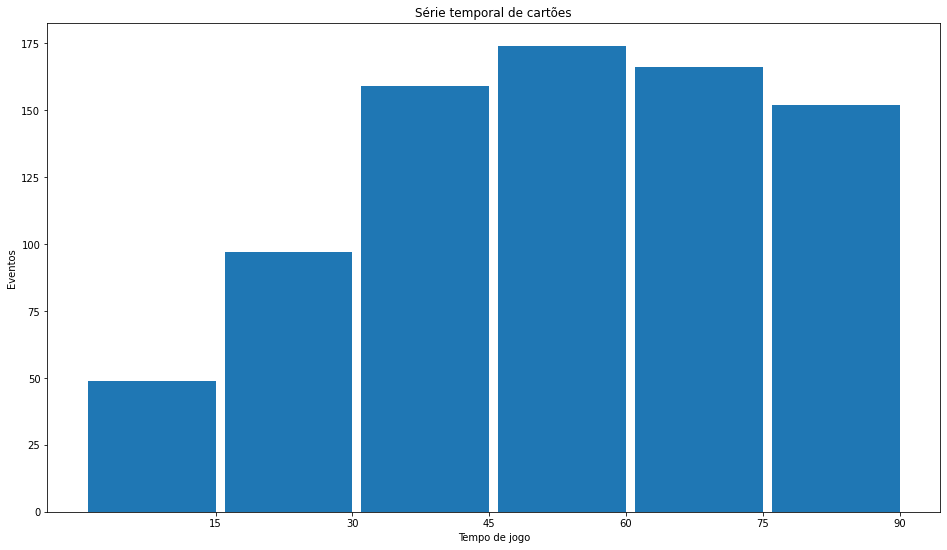

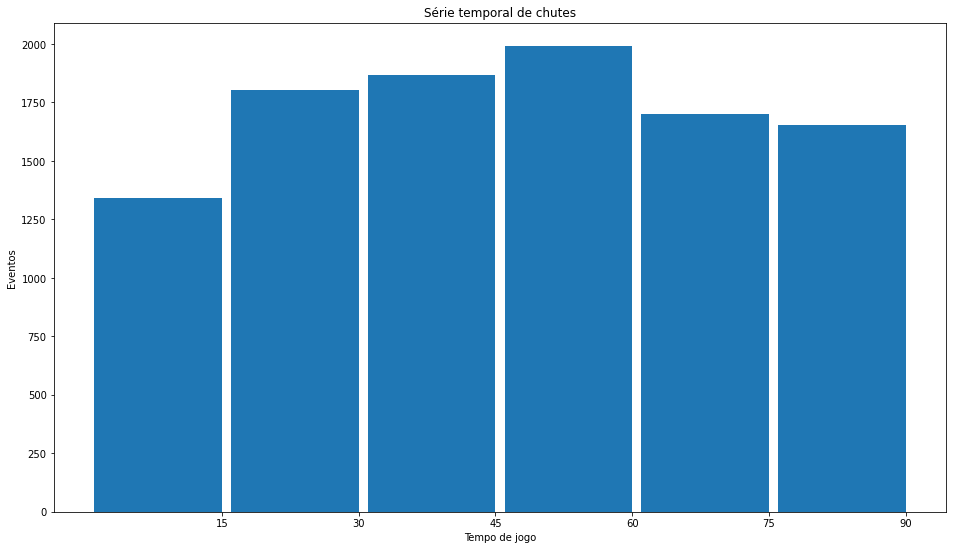

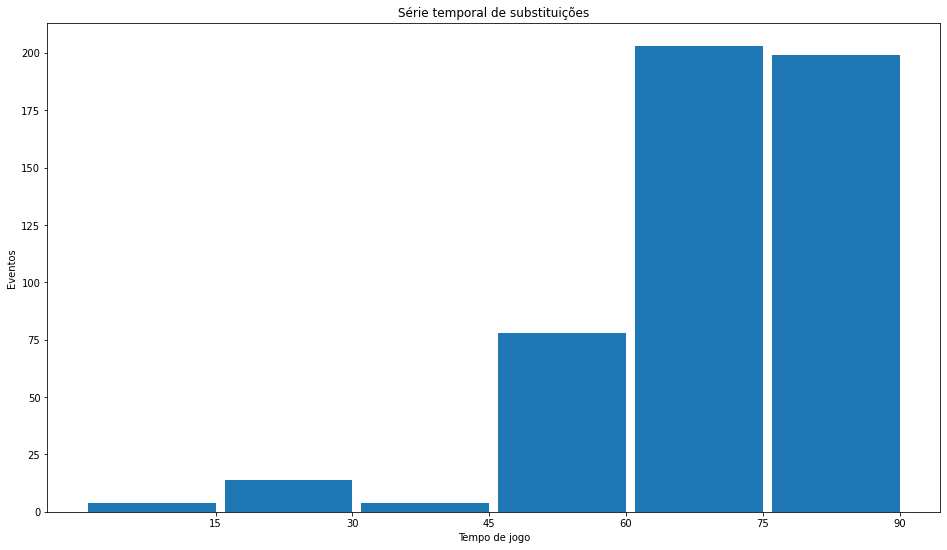

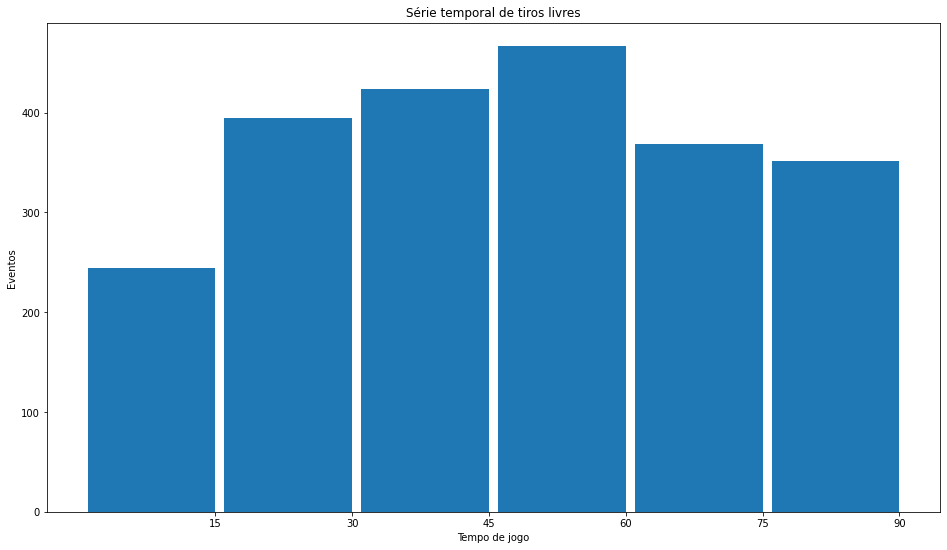

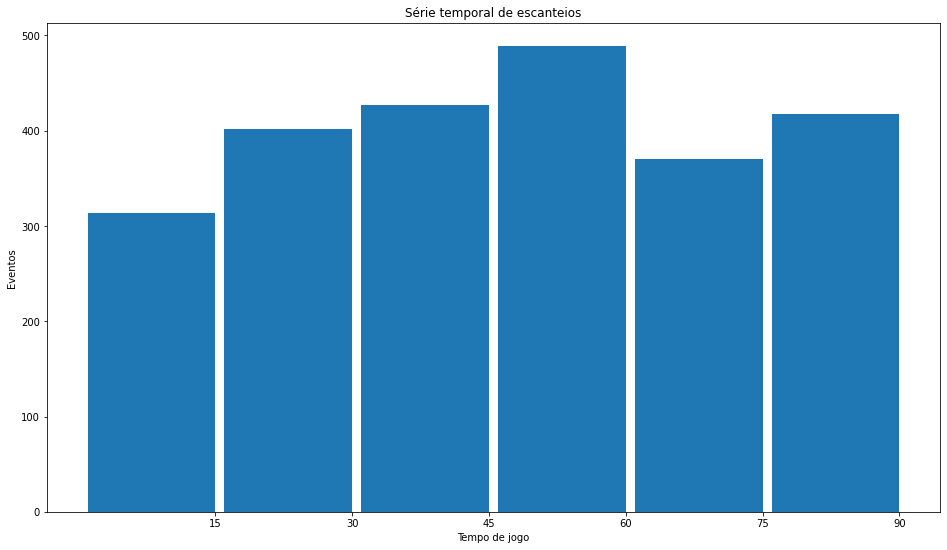

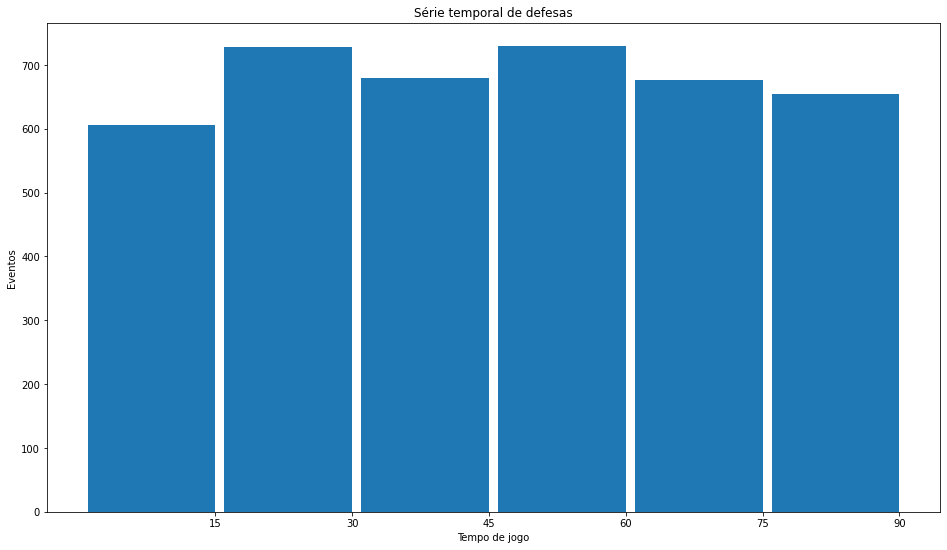

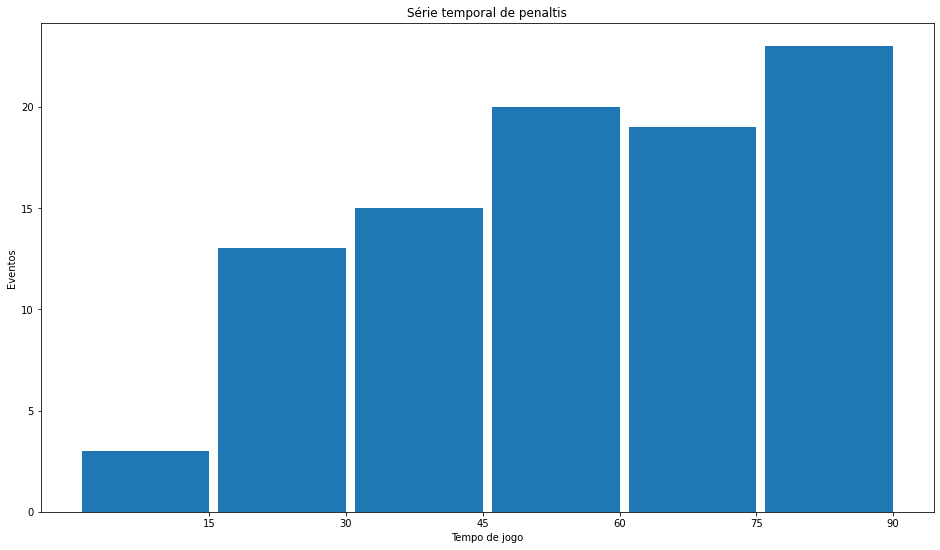

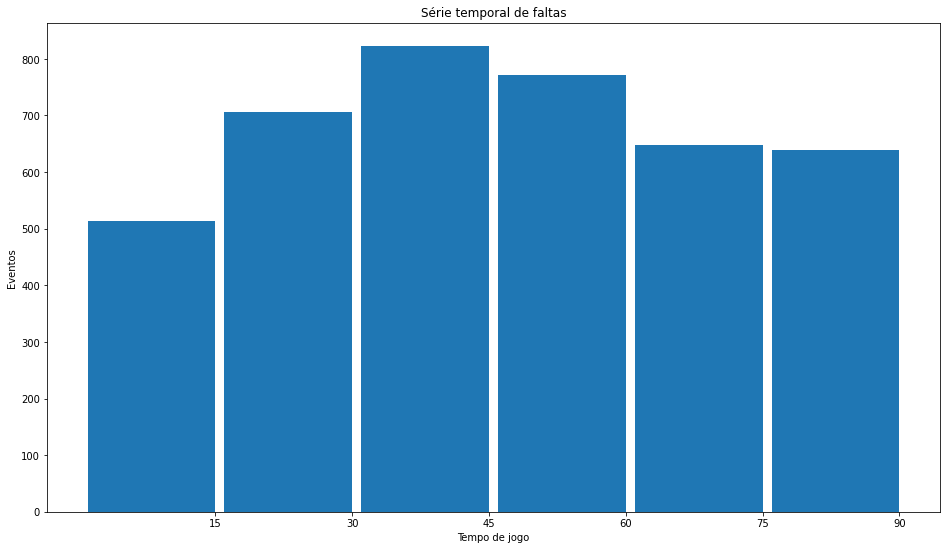

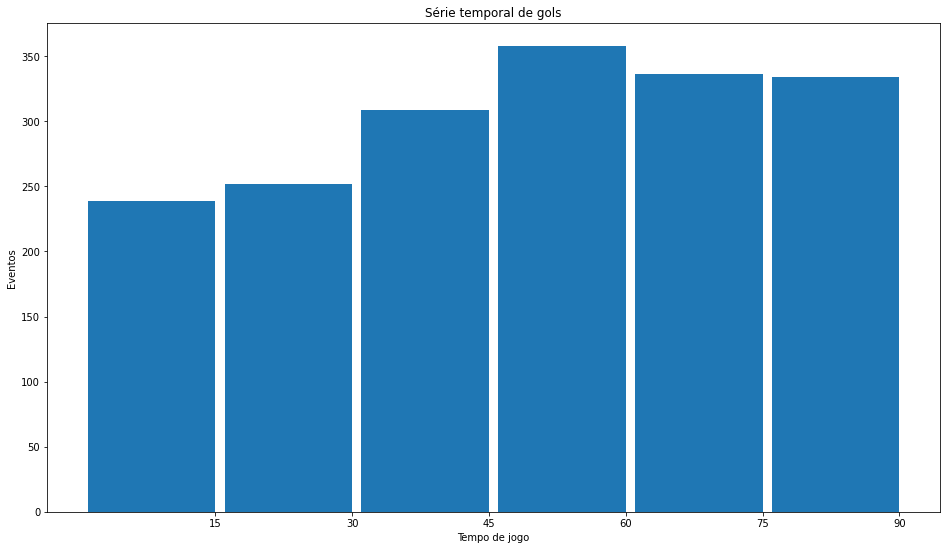

In [ ]:
# Gerando os gráficos de todos os parâmetros que temos
for n in range(1, 11):
  plot_grafico(n)

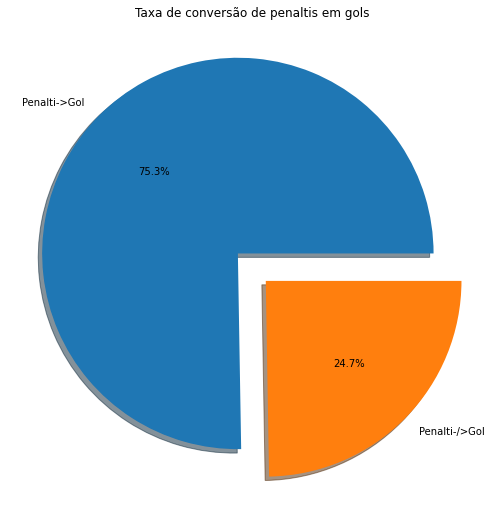

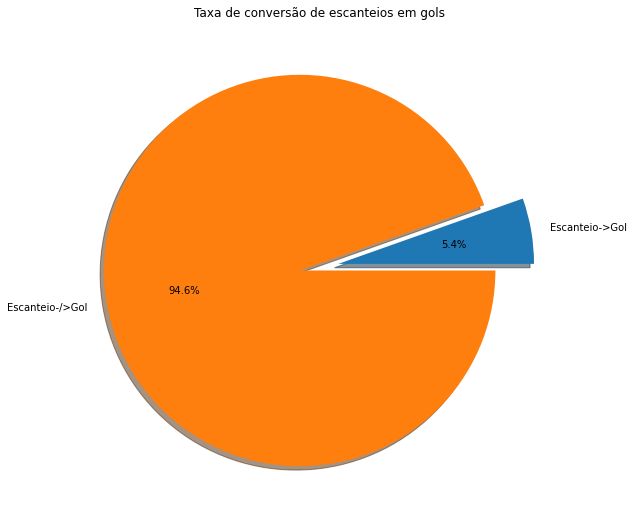

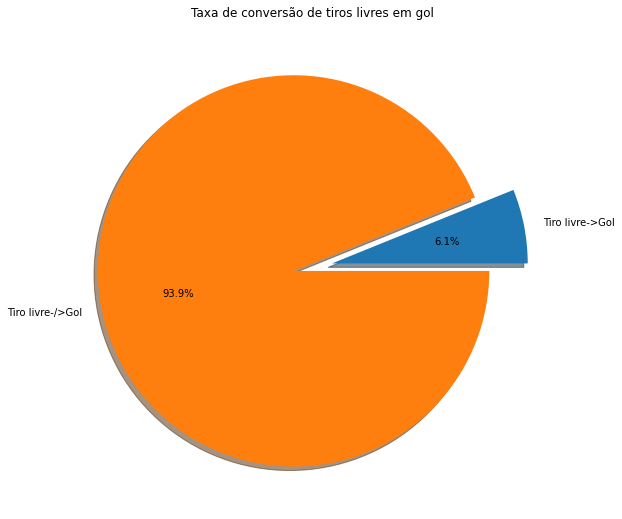

In [ ]:
# Plotando os gráficos de torta, que nos dizem a informação da porcentagem de certo evento ser convertido em gol.

corner = get_conversion(6)
penalti = get_conversion(8)
freekick = get_conversion(5)

plt.pie([penalti, 1-penalti], labels=['Penalti->Gol', 'Penalti-/>Gol'], autopct='%1.1f%%', shadow=True,explode=(0.1, 0.1))
plt.title('Taxa de conversão de penaltis em gols')
plt.show()

plt.pie([corner, 1-corner], labels=['Escanteio->Gol', 'Escanteio-/>Gol'], autopct='%1.1f%%', shadow=True,explode=(0.1, 0.1))
plt.title('Taxa de conversão de escanteios em gols')
plt.show()

plt.pie([freekick, 1-freekick], labels=['Tiro livre->Gol', 'Tiro livre-/>Gol'], autopct='%1.1f%%', shadow=True,explode=(0.1, 0.1))
plt.title('Taxa de conversão de tiros livres em gol')
plt.show()